In [ ]:
pip install lexical-diversity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 2.2 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from wordcloud import WordCloud
from lexical_diversity import lex_div as ld
import os

import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from gensim import corpora
from gensim.models import LsiModel, TfidfModel
from gensim.models.coherencemodel import CoherenceModel

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

**TOPIC MINING**

LSI Topic Modelling, based on SAS TextMiner

In [ ]:
data = pd.read_csv("Data_Master_Sheet_UpAdjDates.csv")

In [ ]:
descriptions = data['web_profile'].astype(str)

In [ ]:
def load_data(path, file_name):
    """
    Load text data from a CSV file.
    """
    df = pd.read_csv(os.path.join(path, file_name))
    documents_list = descriptions.tolist()
    print("Total Number of Documents:", len(documents_list))
    return documents_list

def preprocess_data(doc_set):
    """
    Preprocess text (tokenize, remove stopwords, POS tagging, and stem).
    """
    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = set(stopwords.words('english'))
    p_stemmer = PorterStemmer()

    # Define a set of POS tags to keep (noun, verb, adjective, adverb)
    allowed_pos_tags = {'NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'}

    def pos_filter(tokens):
        """
        Filter tokens based on POS tags.
        """
        tagged_tokens = pos_tag(tokens)
        return [word for word, tag in tagged_tokens if tag in allowed_pos_tags]

    texts = []
    for i in doc_set:
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if i not in en_stop]
        pos_filtered_tokens = pos_filter(stopped_tokens)
        stemmed_tokens = [p_stemmer.stem(i) for i in pos_filtered_tokens]
        texts.append(stemmed_tokens)
    return texts

def prepare_corpus(doc_clean):
    """
    Create term dictionary and Document Term Matrix with TF-IDF weighting.
    """
    dictionary = corpora.Dictionary(doc_clean)

    # Remove low-frequency words
    low_freq_ids = [tokenid for tokenid, docfreq in dictionary.dfs.items() if docfreq < 3]
    dictionary.filter_tokens(bad_ids=low_freq_ids)

    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

    # Apply TF-IDF
    tfidf = TfidfModel(doc_term_matrix)
    doc_term_matrix_tfidf = tfidf[doc_term_matrix]

    return dictionary, doc_term_matrix_tfidf

def create_gensim_lsa_model(doc_clean, number_of_topics):
    dictionary, doc_term_matrix_tfidf = prepare_corpus(doc_clean)
    lsamodel = LsiModel(doc_term_matrix_tfidf, num_topics=number_of_topics, id2word=dictionary)
    return lsamodel, dictionary

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start, step, num_runs=5):
    """
    Compute coherence scores for various number of topics, averaged over multiple runs.
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        temp_coherence_values = []
        for _ in range(num_runs):
            model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary)
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
            temp_coherence_values.append(coherencemodel.get_coherence())
        avg_coherence = np.mean(temp_coherence_values)
        coherence_values.append(avg_coherence)
    return model_list, coherence_values

def plot_graph(doc_clean, start, stop, step, num_runs=5):
    """
    Plot coherence score vs number of topics, averaged over multiple runs.
    """
    dictionary, doc_term_matrix_tfidf = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix_tfidf, doc_clean, stop, start, step, num_runs)
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.legend(["Coherence Values"], loc='best')
    plt.show()

def display_topics(lsamodel, dictionary, num_words=10):
    """
    Display topics and their significant words.
    """
    topics = lsamodel.show_topics(num_topics=-1, num_words=num_words, formatted=False)

    for topic_num, words in topics:
        print(f"Topic {topic_num}:")
        print(" + ".join([f"{word[0]} ({word[1]:.4f})" for word in words]))
        print()


In [ ]:
file_path = ""
file_name = "Data_Master_Sheet_UpAdjDates.csv"
document_list = load_data(file_path, file_name)
clean_text = preprocess_data(document_list)

# Determine optimal number of topics
start, stop, step = 2, 20, 1  # Range of topics to evaluate
num_runs = 5  # Number of runs to average coherence scores
plot_graph(clean_text, start, stop, step, num_runs)

In [ ]:
# Create LSA model with the optimal number of topics
number_of_topics = 4
lsamodel, dictionary = create_gensim_lsa_model(clean_text, number_of_topics)

# Display topics and their significant words
display_topics(lsamodel, dictionary)

Topic 0:
dog (0.1347) + enjoy (0.1311) + need (0.1293) + new (0.1286) + play (0.1257) + love (0.1252) + littl (0.1245) + home (0.1187) + time (0.1182) + famili (0.1160)

Topic 1:
onlin (0.4895) + appli (0.4697) + pleas (0.4231) + offer (0.3736) + feel (0.2399) + home (0.0950) + forev (0.0849) + applic (0.0764) + rehom (0.0698) + suitabl (0.0665)

Topic 2:
live (0.3298) + children (0.2453) + age (0.2046) + need (0.1726) + dog (0.1674) + left (0.1612) + secur (0.1574) + hour (0.1556) + garden (0.1492) + cat (0.1320)

Topic 3:
onlin (0.2654) + rehom (-0.2551) + button (-0.2545) + click (-0.2520) + suitabl (-0.2395) + enquir (-0.2386) + match (-0.2340) + close (-0.2226) + applic (-0.2205) + found (-0.2184)



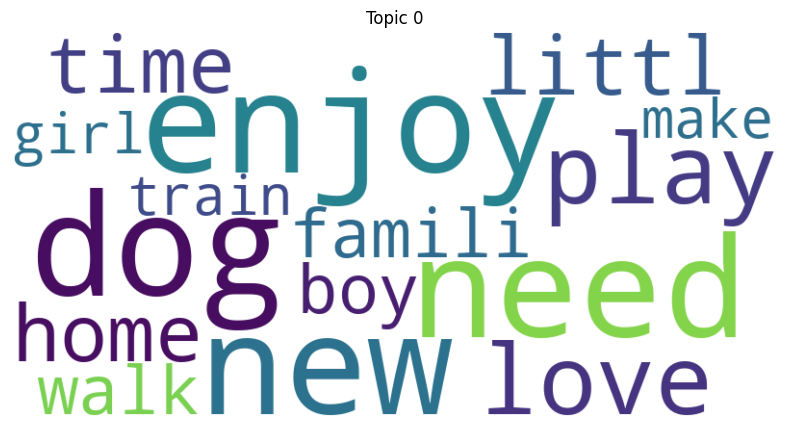

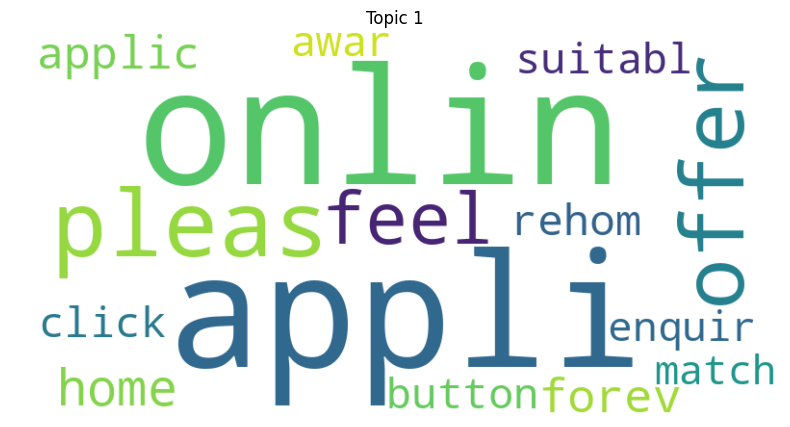

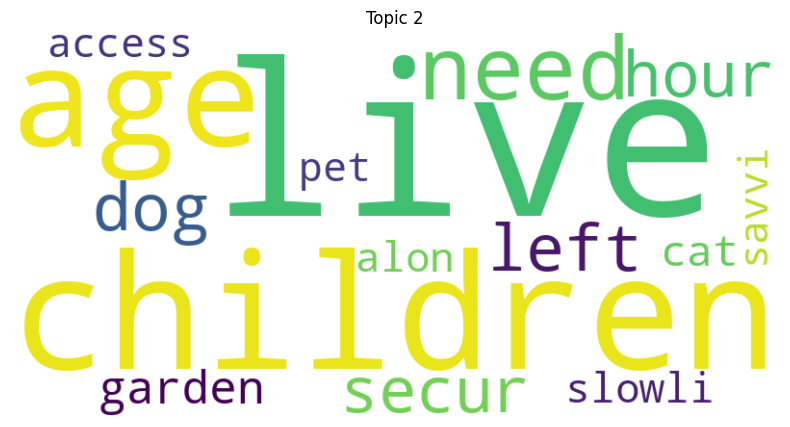

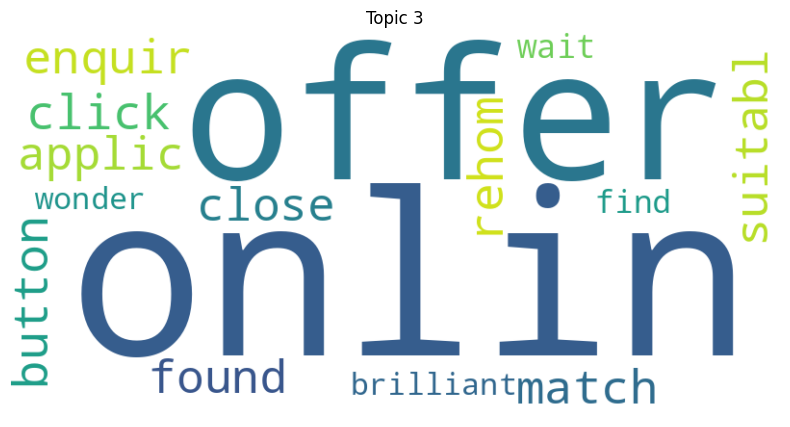

In [ ]:
def plot_word_clouds(lsamodel, num_words=15):
    """
    Plot word clouds for each topic.
    """
    topics = lsamodel.show_topics(num_topics=-1, num_words=num_words, formatted=False)

    for topic_num, words in topics:
        word_freq = dict(words)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Topic {topic_num}")
        plt.axis('off')
        plt.show()

plot_word_clouds(lsamodel)

In [ ]:
file_path = ""
file_name = "Data_Master_Sheet_UpAdjDates.csv"
df = pd.read_csv(file_path + file_name)
descriptions = df['web_profile'].astype(str) #<--------------edit for web or home descriptions
doc_ids = df['id'].astype(str).tolist()

def get_significant_terms(lsamodel, threshold=0.1):
    significant_terms = {}
    for topic_id in range(number_of_topics):
        terms = lsamodel.show_topic(topic_id, topn=500)
        significant_terms[topic_id] = [(term, weight) for term, weight in terms if abs(weight) >= threshold]
    return significant_terms

def get_topic_distribution(doc_term_matrix_tfidf, lsamodel):
    return [lsamodel[doc] for doc in doc_term_matrix_tfidf]

def calculate_document_counts(doc_topic_distributions, threshold=0.1):
    doc_counts = [0] * number_of_topics
    for doc_dist in doc_topic_distributions:
        for topic_id, score in doc_dist:
            if score >= threshold:
                doc_counts[topic_id] += 1
    return doc_counts

def get_top_terms(significant_terms, num_top_terms=5):
    top_terms = {}
    for topic_id, terms in significant_terms.items():
        sorted_terms = sorted(terms, key=lambda x: abs(x[1]), reverse=True)[:num_top_terms]
        top_terms[topic_id] = [term for term, weight in sorted_terms]
    return top_terms

# Prepare document-term matrix
_, doc_term_matrix_tfidf = prepare_corpus(clean_text)

# Get topic distribution for each document
doc_topic_distributions = get_topic_distribution(doc_term_matrix_tfidf, lsamodel)

# Calculate document counts based on topic distribution
doc_counts = calculate_document_counts(doc_topic_distributions, threshold=0.1)

# Get significant terms and top terms
significant_terms = get_significant_terms(lsamodel, threshold=0.1)
top_terms = get_top_terms(significant_terms, num_top_terms=5)

results = []
for topic_id in range(number_of_topics):
    num_significant_terms = len(significant_terms[topic_id])
    top_terms_list = ", ".join(top_terms[topic_id])
    results.append({
        'TopicID': topic_id,
        'NumberOfTerms': num_significant_terms,
        'NumberOfDocs': doc_counts[topic_id],
        'TopTerms': top_terms_list
    })

results_df = pd.DataFrame(results)

print(results_df)

# Create the results DataFrame for documents and their topic distributions
results = []
for doc_id, topic_distribution in zip(doc_ids, doc_topic_distributions):
    topic_scores = {f'Home_Topic_{topic_id}': score for topic_id, score in topic_distribution}
    result = {'id': doc_id}
    result.update(topic_scores)
    results.append(result)

results_df = pd.DataFrame(results)
output_file = "home_topic_mapping.csv"
results_df.to_csv(output_file, index=False)

print(results_df.head())

   TopicID  NumberOfTerms  NumberOfDocs                              TopTerms
0        0             11          3771          need, time, new, train, love
1        1             20            79  pleas, appli, permiss, written, rent
2        2             15           380    puppi, train, class, school, basic
        id  Home_Topic_0  Home_Topic_1  Home_Topic_2
0  1264724      0.145197      0.011218      0.296559
1  1260604      0.277459     -0.281740      0.339538
2  1264725      0.187920      0.016697      0.381323
3  1263006      0.140794      0.033890      0.136746
4  1265056      0.266119      0.007691      0.442477


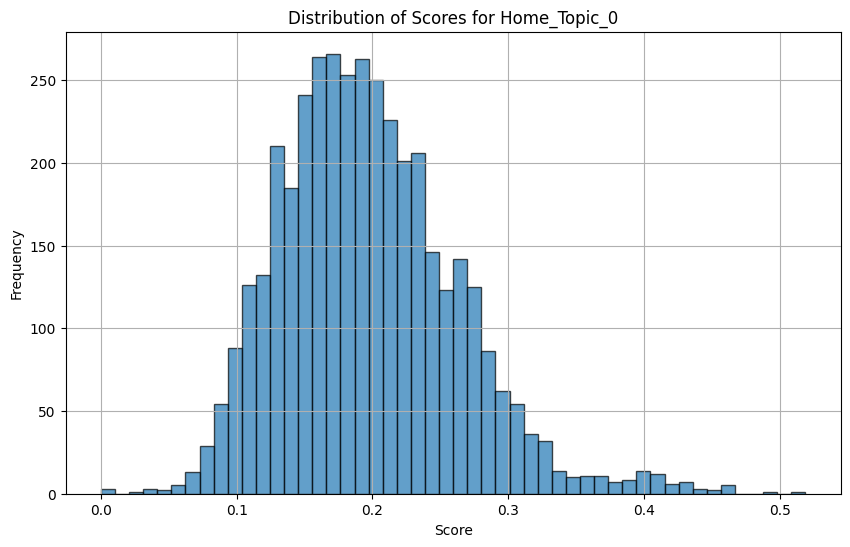

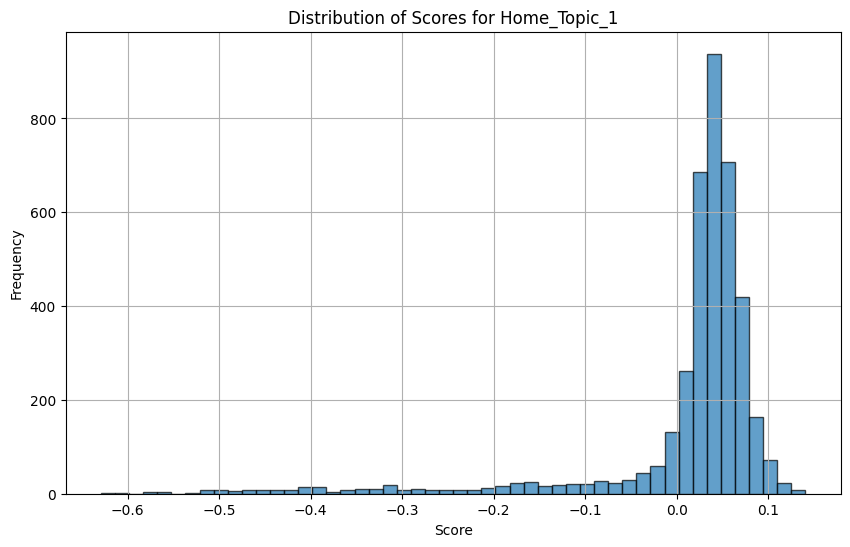

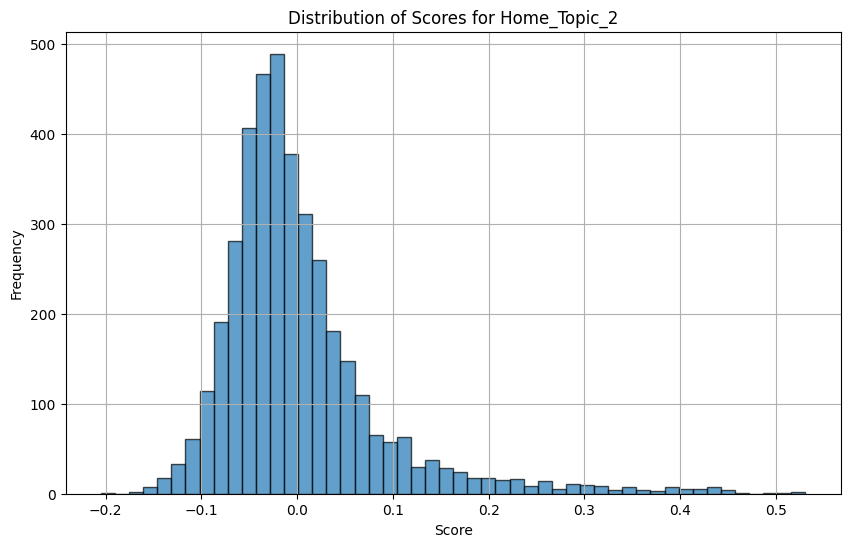

In [ ]:
df = pd.read_csv("home_topic_mapping.csv")

for topic in ['Home_Topic_0', 'Home_Topic_1', 'Home_Topic_2']:
    plt.figure(figsize=(10, 6))
    plt.hist(df[topic], bins=50, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of Scores for {topic}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

FAA Topic Method


In [ ]:
file_path = ""
file_name = "Both_Data_Master_Sheet.csv"
df = pd.read_csv(file_path + file_name)

# List of adjectives from Ley et al. 2008
adjectives =  ["lively", "energetic", "exuberant", "active", "hyperactive", "excitable",
              "enthusiastic", "eager", "quiet", "restless", "obedient", "reliable",
              "trainable", "intelligent", "attentive", "clever", "biddable", "determined",
              "dominant", "assertive", "tenacious", "thorough", "persevering", "independent",
              "proud", "nosey", "nosy", "opportunistic", "easy going", "easygoing", "easy-going", "friendly",
               "non-aggressive", "non aggressive", "nonaggressive",
              "relaxed", "unaggressive", "sociable", "happy-go-lucky", "happy go lucky", "happygolucky", "gentle", "nervous",
              "fearful", "timid", "cautious", "submissive", "sensitive"]

# Convert text to lowercase for consistency
df['web_profile'] = df['web_profile'].astype(str).str.lower().str.lower()
df['home_requirements'] = df['home_requirements'].astype(str).str.lower()

# Filter function to find adjectives in text
def filter_adjectives(text):
    words = text.split()
    return [word for word in words if word in adjectives]

# Apply the filter function to both columns
df['adjectives_web_profile'] = df['web_profile'].apply(lambda x: filter_adjectives(x))
df['adjectives_home_requirements'] = df['home_requirements'].apply(lambda x: filter_adjectives(x))

print(df[['adjectives_web_profile', 'adjectives_home_requirements']].head())


In [ ]:
# List of adjectives with variations
adjectives_dict = {
    "lively": ["lively"],
    "energetic": ["energetic"],
    "exuberant": ["exuberant"],
    "active": ["active"],
    "hyperactive": ["hyperactive"],
    "excitable": ["excitable"],
    "enthusiastic": ["enthusiastic"],
    "eager": ["eager"],
    "quiet": ["quiet"],
    "restless": ["restless"],
    "obedient": ["obedient"],
    "reliable": ["reliable"],
    "trainable": ["trainable"],
    "intelligent": ["intelligent"],
    "attentive": ["attentive"],
    "clever": ["clever"],
    "biddable": ["biddable"],
    "determined": ["determined"],
    "dominant": ["dominant"],
    "assertive": ["assertive"],
    "tenacious": ["tenacious"],
    "thorough": ["thorough"],
    "persevering": ["persevering"],
    "independent": ["independent"],
    "proud": ["proud"],
    "nosey": ["nosey", "nosy"],
    "opportunistic": ["opportunistic"],
    "easy-going": ["easy-going", "easy going", "easygoing"],
    "friendly": ["friendly"],
    "non-aggressive": ["non-aggressive", "non aggressive", "nonaggressive"],
    "relaxed": ["relaxed"],
    "unaggressive": ["unaggressive"],
    "sociable": ["sociable"],
    "happy-go-lucky": ["happy-go-lucky", "happy go lucky", "happygolucky"],
    "gentle": ["gentle"],
    "nervous": ["nervous"],
    "fearful": ["fearful"],
    "timid": ["timid"],
    "cautious": ["cautious"],
    "submissive": ["submissive"],
    "sensitive": ["sensitive"]
}

# Convert text to lowercase for consistency and handle missing values
df['web_profile'] = df['web_profile'].astype(str).str.lower().fillna('')
df['home_requirements'] = df['home_requirements'].astype(str).str.lower().fillna('')

# Combine the two text columns
df['combined_text'] = df['web_profile'] + ' ' + df['home_requirements']

# Function to check if any variation of an adjective is in the text
def contains_adjective_variations(text, variations):
    return any(variation in text for variation in variations)

# Initialize a dictionary to hold the counts
adjective_counts = defaultdict(lambda: {'in_texts': 0, 'not_in_texts': 0})

# Count occurrences
total_texts = len(df)
for adjective, variations in adjectives_dict.items():
    df[adjective] = df['combined_text'].apply(lambda x: contains_adjective_variations(x, variations))
    in_texts = df[adjective].sum()
    not_in_texts = total_texts - in_texts
    adjective_counts[adjective]['in_texts'] = in_texts
    adjective_counts[adjective]['not_in_texts'] = not_in_texts

# Convert the counts to a DataFrame
adjective_df = pd.DataFrame(adjective_counts).T.reset_index()
adjective_df.columns = ['Adjective', 'In_Texts', 'Not_In_Texts']

output_file = "adjective_counts.csv"
adjective_df.to_csv(output_file, index=False)

In [ ]:
# Topic groupings
topics = {
    "Energetic/Extroverted": ["lively", "energetic", "exuberant", "active", "hyperactive", "excitable", "enthusiastic", "eager", "quiet", "restless"],
    "Self-assured/Motivated": ["obedient", "reliable", "trainable", "intelligent", "attentive", "clever", "biddable"],
    "Responsiveness to training": ["determined", "dominant", "assertive", "tenacious", "thorough", "persevering", "independent", "proud", "nosey", "opportunistic"],
    "Friendly/Sociable": ["easy-going", "friendly", "non-aggressive", "relaxed", "unaggressive", "sociable", "happy-go-lucky"],
    "Nervous/Sensitive": ["nervous", "fearful", "timid", "cautious", "submissive", "sensitive"]
}

# Convert text to lowercase for consistency and handle missing values
df['web_profile'] = df['web_profile'].astype(str).str.lower().fillna('')
df['home_requirements'] = df['home_requirements'].astype(str).str.lower().fillna('')

# Combine the two text columns
df['combined_text'] = df['web_profile'] + ' ' + df['home_requirements']

# Function to check if any variation of an adjective is in the text
def contains_adjective_variations(text, variations):
    return any(variation in text for variation in variations)


# Initialize a dictionary to hold the counts and t-test results for each topic
topic_results = defaultdict(lambda: {
    'in_texts': 0,
    'not_in_texts': 0,
    'avg_time_in_texts': None,
    'avg_time_not_in_texts': None,
    't_stat': None,
    'p_value': None
})

# Count occurrences and perform t-test for each topic
total_texts = len(df)
for topic, adjectives in topics.items():
    # Create a boolean column for the topic
    df[topic] = df.apply(lambda row: any(contains_adjective_variations(row['combined_text'], adjectives_dict[adj]) for adj in adjectives), axis=1)

    # Separate data into groups based on the topic
    with_topic = df[df[topic] == True]['time_to_adoption']
    without_topic = df[df[topic] == False]['time_to_adoption']

    # Count occurrences
    in_texts = with_topic.count()
    not_in_texts = without_topic.count()

    # Compute average time_to_adoption
    avg_time_in_texts = with_topic.mean() if in_texts > 0 else None
    avg_time_not_in_texts = without_topic.mean() if not_in_texts > 0 else None

    topic_results[topic]['in_texts'] = in_texts
    topic_results[topic]['not_in_texts'] = not_in_texts
    topic_results[topic]['avg_time_in_texts'] = avg_time_in_texts
    topic_results[topic]['avg_time_not_in_texts'] = avg_time_not_in_texts


topic_df = pd.DataFrame(topic_results).T.reset_index()
topic_df.columns = ['Topic', 'In_Texts', 'Not_In_Texts', 'Avg_Time_In_Texts', 'Avg_Time_Not_In_Texts', 'T_Statistic', 'P_Value']

output_file = "topic_comparison_with_ttest.csv"
topic_df.to_csv(output_file, index=False)

In [ ]:

file_path = ""
file_name = "Both_Data_Master_Sheet.csv"
df = pd.read_csv(file_path + file_name)

# Convert text to lowercase for consistency and handle missing values
df['web_profile'] = df['web_profile'].astype(str).str.lower().fillna('')
df['home_requirements'] = df['home_requirements'].astype(str).str.lower().fillna('')

# Combine the two text columns
df['combined_text'] = df['web_profile'] + ' ' + df['home_requirements']

# Add columns for each topic indicating presence or absence
for topic, adjectives in topics.items():
    df[topic] = df.apply(
        lambda row: 1 if any(contains_adjective_variations(row['combined_text'], adjectives_dict[adj]) for adj in adjectives) else 0,
        axis=1
    )

print(df.head())

output_file = "updated_data_with_topics.csv"
df.to_csv(output_file, index=False)

**Other NLP Techniques Used**

Sentiment Score

In [ ]:
file_path = ""
file_name = "Data_Master_Sheet_UpAdjDates.csv"
df = pd.read_csv(file_path + file_name)

# Initialize the VADER sentiment intensity analyzer
sid = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment scores
def get_sentiment_scores(text):
    sentiment = sid.polarity_scores(text)
    return sentiment['compound']

# Calculate sentiment scores for each description
df['sentiment_score_web'] = df['web_profile'].astype(str).apply(get_sentiment_scores)
df['sentiment_score_home'] = df['home_requirements'].astype(str).apply(get_sentiment_scores)

# Select the relevant columns
output_df = df[['id', 'sentiment_score_web', 'sentiment_score_home']]

output_file = "document_sentiment_scores.csv"
output_df.to_csv(output_file, index=False)

Length Measures

In [ ]:
# Define a function to calculate the length of the description
def calculate_length(text):
    return len(text)

# Define a function to calculate the number of words in the description
def calculate_word_count(text):
    words = word_tokenize(text)
    return len(words)

# Define a function to calculate the number of tokens in the description
def calculate_token_count(text):
    tokens = word_tokenize(text)
    return len(tokens)

# Calculate the length, word count, and token count of each description
df['web_no_characters'] = df['web_profile'].astype(str).apply(calculate_length)
df['web_word_count'] = df['web_profile'].astype(str).apply(calculate_word_count)
df['web_token_count'] = df['web_profile'].astype(str).apply(calculate_token_count)
df['home_no_characters'] = df['home_requirements'].astype(str).apply(calculate_length)
df['home_word_count'] = df['home_requirements'].astype(str).apply(calculate_word_count)
df['home_token_count'] = df['home_requirements'].astype(str).apply(calculate_token_count)

# Select the relevant columns
output_df = df[['id', 'web_description_length', 'web_word_count', 'web_token_count', 'home_description_length', 'home_word_count', 'home_token_count']]

output_file = "document_description_metrics.csv"
output_df.to_csv(output_file, index=False)

In [ ]:
# Plot the distribution of token counts
plt.figure(figsize=(12, 6))
sns.histplot(df['token_count'], bins=5, kde=True)
plt.title('Distribution of Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

# Calculate and display descriptive statistics
token_count_stats = df['token_count'].describe()
print(token_count_stats)

Lexical Diversity - MATTR as most stable index of lexical diversity

In [ ]:
# Define a function to calculate the MATTR score
def calculate_mattr(text):
    tokens = word_tokenize(text)
    return ld.mattr(tokens)

# Calculate the MATTR score for each description
df['web_mattr_score'] = df['web_profile'].astype(str).apply(calculate_mattr)
df['home_mattr_score'] = df['home_requirements'].astype(str).apply(calculate_mattr)

output_file_name = "Data_With_MATTR_Scores.csv"
df.to_csv(file_path + output_file_name, index=False)

In [ ]:
# Plot the distribution of MATTR scores
plt.figure(figsize=(10, 6))
sns.histplot(df['mattr_score'], bins=30, kde=True)
plt.title('Distribution of MATTR Scores')
plt.xlabel('MATTR Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Lexical Density - Ure's method

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Define a function to calculate lexical density using Ure's method
def calculate_lexical_density(text):
    tokens = word_tokenize(text)
    tagged = nltk.pos_tag(tokens)

    lexical_words = [word for word, pos in tagged if pos.startswith('N') or pos.startswith('V') or pos.startswith('J') or pos.startswith('R')]
    lexical_density = len(lexical_words) / len(tokens) if tokens else 0
    return lexical_density

# Calculate the lexical density for each description
df['web_lexical_density'] = df['web_profile'].astype(str).apply(calculate_lexical_density)
df['home_lexical_density'] = df['home_requirements'].astype(str).apply(calculate_lexical_density)

output_file = "lexical_density_output.csv"
df.to_csv(output_file, index=False)

In [ ]:
# Plot the distribution of MATTR scores
plt.figure(figsize=(10, 6))
sns.histplot(df['lexical_density'], bins=30, kde=True)
plt.title('Distribution of LDens Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Combine all the text measure on to the CSV

In [ ]:
# Calculate the new columns
df['web_no_characters'] = df['web_profile'].astype(str).apply(calculate_length)
df['web_token_count'] = df['web_profile'].astype(str).apply(calculate_token_count)
df['web_lexical_diversity'] = df['web_profile'].astype(str).apply(calculate_mattr)
df['web_lexical_density'] = df['web_profile'].astype(str).apply(calculate_lexical_density)
df['web_sentiment_score'] = df['web_profile'].astype(str).apply(get_sentiment_scores)
df['home_no_characters'] = df['home_requirements'].astype(str).apply(calculate_length)
df['home_token_count'] = df['home_requirements'].astype(str).apply(calculate_token_count)
df['home_lexical_diversity'] = df['home_requirements'].astype(str).apply(calculate_mattr)
df['home_lexical_density'] = df['home_requirements'].astype(str).apply(calculate_lexical_density)
df['home_sentiment_score'] = df['home_requirements'].astype(str).apply(get_sentiment_scores)

output_file = "Text_Data_Master_Sheet.csv"
df.to_csv(output_file, index=False)
